In [1]:
import sys,os,importlib,gc,glob,pickle, string
import xarray as xr
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

os.chdir('/home/peter/Projects/tc_emulator/results')

sys.path.append('../scripts')
import _weather_pattern_class; importlib.reload(_weather_pattern_class)

atl = _weather_pattern_class.weather_patterns(source='ERA5', working_directory='./')


In [2]:
# for plotting sdfsd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import matplotlib as mpl
from matplotlib import colors
import cartopy
import cartopy.crs as ccrs

# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
# matplotlib.rcParams['font.family'] = 'sans-serif'

In [3]:
atl.load_input('ERA5_VWS-MSLP_noTC3')
years = np.array(range(1982,2021))
atl.set_split(years=years)

In [4]:
nrows,ncols = 5,4
tag = 'SOM_pcaInit%sx%s_v1' % (nrows,ncols)
atl.define_plot_environment(pre_mapping='mapping_raw', clustering=tag, post_mapping='mapping_sammon_1982-2020', nrows=nrows, ncols=ncols)
atl.stats_TC(file='tracks/tracks_ibtracks.csv', overwrite=False)

{'SOM': <minisom.MiniSom object at 0x7f9ab47db880>}
.//ERA5_VWS-MSLP_noTC3/mapping_raw_1982-2020/SOM_pcaInit5x4_v1/mapping_sammon_1982-2020/grid_5x4


In [5]:
####################################################
# weather pattern TS and SST TS for iconic seasons #
####################################################
# order weather patterns according to ACE
favOrder = pd.DataFrame()
for lab in range(20):
    favOrder = favOrder.append({'weather':lab, 'ACE':float(atl._tracks.loc[(atl._tracks['label_lag0']==lab), 'ACE'].sum() / np.sum(atl._clust_labels==lab))}, ignore_index=True)


favOrder['score'] = 0
favOrder.loc[favOrder.ACE > np.nanpercentile(favOrder.ACE, 25), 'score'] = 2
favOrder.loc[favOrder.ACE > np.nanpercentile(favOrder.ACE, 50), 'score'] = 4
favOrder.loc[favOrder.ACE > np.nanpercentile(favOrder.ACE, 75), 'score'] = 6

favOrder


,weather,ACE,score
0,0.0,3.177207,6
1,1.0,0.563320,2
2,2.0,0.472685,0
3,3.0,0.440000,0
4,4.0,1.950519,6
5,5.0,0.618716,2
6,6.0,0.441780,0
7,7.0,0.659504,4
8,8.0,1.357013,4
9,9.0,1.487383,4


In [6]:
#########################
# weather fav indicator and its trend #
#########################
fav = xr.DataArray(favOrder.ACE, coords={'time':favOrder.weather}, dims=['time'])
wFav = fav.loc[atl._clust_labels.values]
wFav = wFav.assign_coords(time=atl._vector_time.values)
wFav = wFav[wFav.time.dt.year >= 1982]

import statsmodels.api as sm
tt = wFav.time.dt.year.values * 365 + wFav.time.dt.month.values * 30 + wFav.time.dt.day.values - 1982 * 365
lr = sm.OLS(wFav.values, sm.add_constant(tt)).fit()
print(lr.summary())

print(wFav.loc[wFav.time.dt.year >= 2009].mean())
print(wFav.loc[wFav.time.dt.year <= 1992].mean())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     113.3
Date:                Tue, 18 Jan 2022   Prob (F-statistic):           4.52e-26
Time:                        15:48:40   Log-Likelihood:                -4326.6
No. Observations:                3588   AIC:                             8657.
Df Residuals:                    3586   BIC:                             8670.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8349      0.027     30.594      0.0

In [7]:
# get sst
sst_MDR = xr.load_dataset('/home/peter/Projects/data/SST/OISST_sst_MDR_1981-2019_daily.nc')['sst']
sst_MDR = sst_MDR[np.isin(sst_MDR.time.dt.year,years)]
sst_MDR = sst_MDR[np.isin(sst_MDR.time.dt.month,atl._months['mon'])]
sst_MDR = sst_MDR.assign_coords(time=np.array([str(d)[:10] for d in sst_MDR.time.values], np.datetime64))


In [8]:

yr_d = {
    # 1995 : {'loc':3.9, 'c':'c', 'shift':0},
    1983 : {'loc':4.3, 'c':'orange', 'shift':-0.4},
    2009 : {'loc':3.5, 'c':'c', 'shift':0},
    # 2017 : {'loc':3.5, 'c':'m', 'shift':0.4},
    2020 : {'loc':3.5, 'c':'m', 'shift':0.4},
    # 2010 : {'c':'r', 'shift':-0.4}
}

In [9]:
tag = 'gWeaLag2Weight_sLWeaNeigh_wS100nnQrSST_Emu0'
emu_path = '/home/peter/Projects/tc_emulator/results/ERA5_VWS-MSLP_noTC3/mapping_raw_1982-2020/SOM_pcaInit5x4_v1/mapping_sammon_1982-2020/grid_5x4/emulator/'
simus = {}
maxStorm = xr.DataArray(0., coords={'year':list(yr_d.keys()),'day':range(92), 'run':range(1000)}, dims=['year','run','day'])
sims = xr.DataArray(0., coords={'year':list(yr_d.keys()),'day':range(92), 'run':range(1000)}, dims=['year','run','day'])
for year in yr_d.keys():
    for tp in [tp.split('/')[-1] for tp in glob.glob(emu_path+'*')]:
        if len(tp) == 9:
            if year in range(int(tp.split('-')[0]),int(tp.split('-')[1])+1):
                break
    outFile = emu_path+tp+'/'+tag+'/sim/'+tag+'_'+str(year)+'_N1000_stormDays.pkl'
    if os.path.isfile(outFile):
        maxStorm.loc[year] = xr.open_dataset(outFile)['maxStorm']
    else:
        simus[year] = pickle.load(open(emu_path+tp+'/'+tag+'/sim/'+tag+'_'+str(year)+'_N1000.pkl', 'rb'))
        for run in sims.run.values:
            for gD,storm in simus[year][run].items():
                for d,w in enumerate(storm):
                    sims.loc[year,run,gD+d] = w**2 / 10000 * 4
                    maxStorm.loc[year,run,gD+d] = max([w,maxStorm.loc[year,run,gD+d]])

        xr.Dataset({'maxStorm':maxStorm.loc[year]}).to_netcdf(outFile)


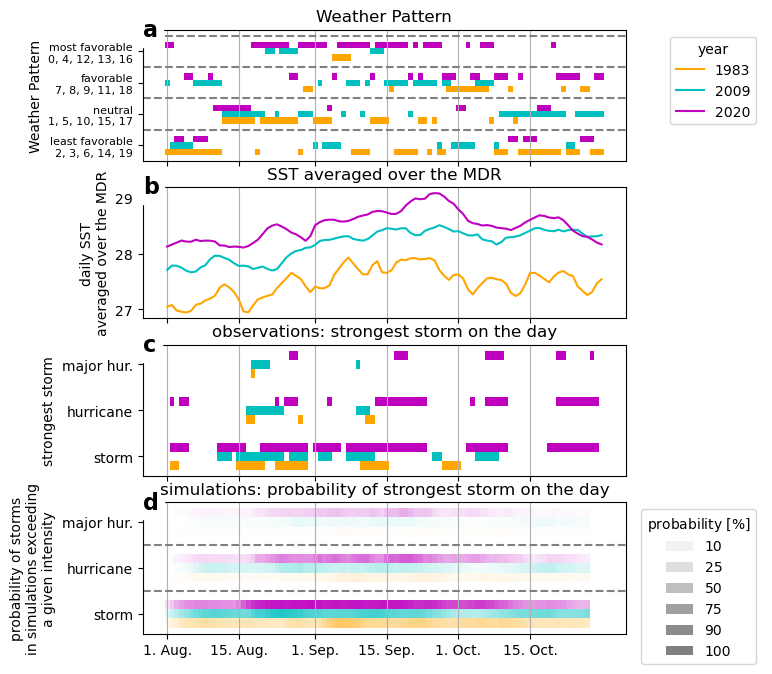

In [13]:
fig,axes = plt.subplots(nrows=4, ncols=2, figsize=(8,8), dpi=100, facecolor='w', sharex=True, gridspec_kw={'width_ratios':[6,1]})
for ax in axes[:,0]:
    ax.grid(zorder=0, axis='x')
for ax in axes[:,1]:
    ax.axis('off')
axLegYr = axes[0,1]
axLegP = axes[3,1]
axW = axes[0,0]
axSST = axes[1,0]
axOBS = axes[2,0]
axSIM = axes[3,0]
ace_d = {0:0,64:2,96:4}

for year,DT in yr_d.items():
    axLegYr.plot([],[], color=DT['c'], label=year)

    tmp = atl._clust_labels[[str(year) in tt for tt in atl._clust_labels.tt.values]]
    axSST.plot(sst_MDR.loc[sst_MDR.time.dt.year == year], color=DT['c'])
    tr_ = atl._tracks.loc[atl._tracks.year == year]

    for d,lab in enumerate(tmp.values):
        score = favOrder.score.values[lab]
        axW.fill_between([d-0.5,d+0.5],[score+DT['shift']-0.2]*2,[score+DT['shift']+0.2]*2, facecolor=DT['c'], edgecolor='none')

    tr_['day_in_season'] = [{8:0,9:31,10:61}[m] + d for d,m in zip(tr_.day,tr_.month)]
    maxW = [tr_.loc[tr_.day_in_season == d, 'wind'].max() for d,lab in enumerate(tmp.values)]
    for ace,y in ace_d.items():
        # maxi = np.sum(maxStorm.loc[:,:,:]>ace, axis=1).max('day').max('year')
        maxi = 1000
        for d,lab in enumerate(tmp.values):
            axSIM.fill_between([d-0.5,d+0.5], [y + DT['shift']-0.2]*2,[y + DT['shift']+0.2]*2, facecolor=DT['c'], 
                               alpha=float(np.sum(maxStorm.loc[year,:,d]>ace) / maxi), edgecolor='none')

        for d,lab in enumerate(tmp.values):
            if maxW[d] > ace:
                axOBS.fill_between([d-0.5,d+0.5], [y + DT['shift']-0.2]*2,[y + DT['shift']+0.2]*2, facecolor=DT['c'], edgecolor='none')
    # axOBS.plot(sims.loc[year].mean('run'), color=DT['c'], linestyle='--')
    # for i in range(100):
    #     axOBS.plot(sims.loc[year][i], color=DT['c'], linestyle='--', alpha=0.1)
    # axOBS.plot( np.percentile(sims.loc[year],90, axis=0), color=DT['c'], linestyle='--')
    # axOBS.fill_between(range(92), np.percentile(sims.loc[year],75, axis=0), np.percentile(sims.loc[year],100, axis=0), color=DT['c'], alpha=0.3)

for y in list(ace_d.values())[:-1]:
    axSIM.axhline(y+1, color='gray', linestyle='--')

score_names = ['least favorable', 'neutral', 'favorable', 'most favorable']
cats = {}
for score,name in zip(np.unique(favOrder.score), score_names):
    axW.axhline(score+1, color='gray', linestyle='--')
    cats[score] = name+'\n'+', '.join([str(int(w)) for w in favOrder.loc[favOrder.score == score, 'weather'].values])

for p in [10,25,50,75,90,100]:
    axLegP.fill_between([], [], [], facecolor='gray', alpha=p/100, edgecolor='none', label='%s' %(p))
axLegP.set_ylim(-99,-9)
axLegP.legend(title='probability [$\%$]')
axLegYr.legend(title='year')

axW.set_title('Weather Pattern')
axW.set_ylabel('Weather Pattern')
axW.set_yticks(list(cats.keys()))
axW.set_yticklabels(list(cats.values()), fontsize=8)

axSST.set_title('SST averaged over the MDR')
axSST.set_ylabel('daily SST\naveraged over the MDR')

axOBS.set_title('observations: strongest storm on the day')
axOBS.set_ylabel('strongest storm')
axOBS.set_yticks(list(ace_d.values()))
axOBS.set_yticklabels(['storm','hurricane','major hur.'])

axSIM.set_title('simulations: probability of strongest storm on the day')
axSIM.set_ylabel('probability of storms\nin simulations exceeding\na given intensity')
axSIM.set_yticks(list(ace_d.values()))
axSIM.set_yticklabels(['storm','hurricane','major hur.'])

axOBS.set_xticks([0,15,31,46,61,76])
axOBS.set_xticklabels(['1. Aug.', '15. Aug.', '1. Sep.', '15. Sep.', '1. Oct.', '15. Oct.'])

for ax,letter in zip([axW,axSST,axOBS,axSIM],['a','b','c','d']):
    ax.annotate(letter, xy=(0,0.95), xycoords='axes fraction', fontweight='bold', fontsize=16, backgroundcolor='w')

plt.savefig(atl._dir_lvl4+'/emulator_single_years.png', bbox_inches='tight', dpi=600)


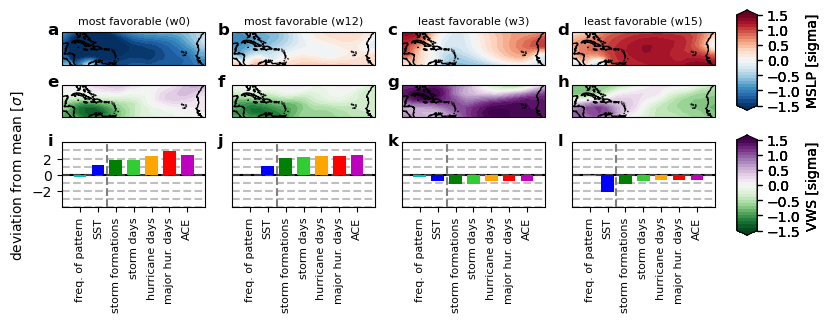

In [14]:
####################################
# Fig. 2 selected weather patterns standardized anomalies #
####################################
weathers = [0,12,3,15]
weather_fav = ['most favorable','most favorable','least favorable','least favorable']
fig, axes = plt.subplots(nrows=3, ncols=len(weathers)+1, figsize=(10,2.5), dpi=100, facecolor='w', sharey='row', gridspec_kw={'height_ratios':[1,1,2], 'width_ratios':[3,3,3,3,2]}, subplot_kw={'projection':ccrs.PlateCarree()})
ims = {}
for c,lab in enumerate(weathers):
    for i,var,cmap in zip([0,1],['MSLP','VWS'],['RdBu_r','PRGn_r']):
        ax = axes[i,c]
        ax.coastlines()
        ax.set_extent([atl._lon.min(),atl._lon.max(),atl._lat.min(),atl._lat.max()], crs=ccrs.PlateCarree())
        tmp_field = atl._vector[:,(atl._vector_var==var)].values.reshape(atl._vector.shape[0],len(atl._lat),len(atl._lon))
        tmp = tmp_field[atl._clust_labels.values==lab,:,:].mean(0)
        ims[var] = ax.contourf(atl._lon, atl._lat, tmp, cmap=cmap, levels=np.linspace(-1.5,1.5,31), extend='both')
    ax = axes[2,c]
    ax.set_extent([atl._lon.min(),atl._lon.max(),0,(atl._lat.max()-atl._lat.min())*2], crs=ccrs.PlateCarree())
    ax.outline_patch.set_edgecolor('w')
    ax = fig.add_axes(ax.get_position(), zorder=2)
    ax.axhline(y=0, color='k', zorder=0)
    yAll = np.array([np.sum(atl._clust_labels==l) / float(atl._clust_labels.shape[0]) for l in np.unique(atl._clust_labels)])
    y = np.sum(atl._clust_labels==lab) / float(atl._clust_labels.shape[0])
    ref_ = yAll.mean()
    std_ = yAll.std()
    ax.bar(x=0, height=(y-0.05) / 0.05, width=0.7, color='c')

    tSST = np.array([str(d)[:10] for d in sst_MDR.time.values], np.datetime64)
    tWeather = np.array([str(d)[:10] for d in atl._vector_time.values], np.datetime64)
    yAll = np.array([float(sst_MDR.loc[np.isin(tSST, tWeather[atl._clust_labels==l])].mean().values) for l in np.unique(atl._clust_labels)])
    y = sst_MDR.loc[np.isin(tSST, tWeather[atl._clust_labels==lab])].mean().values
    ref_ = yAll.mean()
    std_ = yAll.std()
    ax.bar(x=1, height=(y-ref_) / std_, width=0.7, color='blue', zorder=2)

    yall = np.array([float(atl._tracks.loc[(atl._tracks['label_lag0']==l), 'genesis'].sum()) / np.sum(atl._clust_labels==l) for l in np.unique(atl._clust_labels)])
    y = float(atl._tracks.loc[(atl._tracks['label_lag0']==lab), 'genesis'].sum()) / np.sum(atl._clust_labels==lab)
    ref_ = yall.mean()
    std_ = yall.std()
    ax.bar(x=2, height=(y-ref_) / std_, width=0.7, color='green', zorder=2)

    yall = np.array([float(atl._tracks.loc[(atl._tracks['label_lag0']==l)].shape[0]) / np.sum(atl._clust_labels==l) for l in np.unique(atl._clust_labels)])
    y = float(atl._tracks.loc[(atl._tracks['label_lag0']==lab)].shape[0]) / np.sum(atl._clust_labels==lab)
    ref_ = yall.mean()
    std_ = yall.std()
    ax.bar(x=3, height=(y-ref_) / std_, width=0.7, color='limegreen', zorder=2)

    yall = np.array([np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==l), 'wind'] >= 64) / np.sum(atl._clust_labels==l) for l in np.unique(atl._clust_labels)])
    y = np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==lab), 'wind'] >= 64) / np.sum(atl._clust_labels==lab)
    ref_ = yall.mean()
    std_ = yall.std()
    ax.bar(x=4, height=(y-ref_) / std_, width=0.7, color='orange', zorder=2)

    yall = np.array([np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==l), 'wind'] >= 96) / np.sum(atl._clust_labels==l) for l in np.unique(atl._clust_labels)])
    y = np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==lab), 'wind'] >= 96) / np.sum(atl._clust_labels==lab)
    ref_ = yall.mean()
    std_ = yall.std()
    ax.bar(x=5, height=(y-ref_) / std_, width=0.7, color='red', zorder=2)

    yall = np.array([np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==l), 'ACE'].sum()) / np.sum(atl._clust_labels==l) for l in np.unique(atl._clust_labels)])
    y = np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==lab), 'ACE'].sum()) / np.sum(atl._clust_labels==lab)
    ref_ = yall.mean()
    std_ = yall.std()
    ax.bar(x=6, height=(y-ref_) / std_, width=0.7, color='m', zorder=2)

    ax.axvline(x=1.5, linestyle='--', color='gray', zorder=0)

    if c == 0:
        ax.set_ylabel('deviation from mean [$\sigma$]')
        ax.set_yticks([-2,0,2])
    else:
        ax.set_yticks([])
    ax.set_xlim(-1,7)
    ax.set_ylim(-4,4)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['freq. of pattern','SST','storm formations', 'storm days','hurricane days','major hur. days','ACE'], fontsize=8, rotation=90)
    for i in range(-4,5):
        ax.axhline(y=i, color='gray', zorder=0, alpha=0.5, linestyle='--')

    axes[0,c].set_title('%s (w%s)' %(weather_fav[c],lab), fontsize=8)

    for ax in axes[:,-1]:
        ax.outline_patch.set_edgecolor('w')

    cax = plt.axes([0.8, 0.55, 0.02, 0.4])
    cb = fig.colorbar(ims['MSLP'], cax=cax, orientation="vertical", label='MSLP [sigma]', ticks=[-1.5,-1,-0.5,0,0.5,1,1.5])

    cax = plt.axes([0.8, 0.05, 0.02, 0.4])
    cb = fig.colorbar(ims['VWS'], cax=cax, orientation="vertical", label='VWS [sigma]', ticks=[-1.5,-1,-0.5,0,0.5,1,1.5])

for ax,letter in zip(axes[:,:-1].flatten(),list(string.ascii_lowercase)):
    ax.annotate(letter, xy=(-0.1,0.95), xycoords='axes fraction', fontweight='bold', fontsize=12, backgroundcolor='none',zorder=100)

#plt.tight_layout()
plt.savefig(atl._dir_lvl4+'/selected_weather.png', bbox_inches='tight', dpi=600)


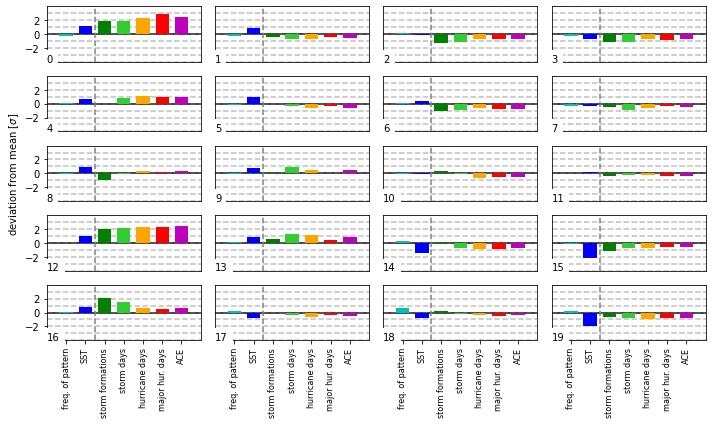

In [12]:
####################################
# stats for all weather patterns standardized anomalies #
####################################
weathers = np.unique(atl._clust_labels)
fig,axes = plt.subplots(nrows=atl._nrows, ncols=atl._ncols, figsize=(atl._nrows*2,atl._ncols*6*(len(atl._lat)/len(atl._lon))))
for lab in np.unique(atl._clust_labels):
    r,c = atl._axes_grid[atl._grid_labels==lab][0][0],atl._axes_grid[atl._grid_labels==lab,1][0]
    ax = axes[r,c]
    ax.annotate(lab, xy=(0,0), xycoords='axes fraction', backgroundcolor='w')
    ax.axhline(y=0, color='k', zorder=0)

    yAll = np.array([np.sum(atl._clust_labels==l) / float(atl._clust_labels.shape[0]) for l in np.unique(atl._clust_labels)])
    y = np.sum(atl._clust_labels==lab) / float(atl._clust_labels.shape[0])
    ref_ = yAll.mean()
    std_ = yAll.std()
    ax.bar(x=0, height=(y-0.05) / 0.05, width=0.7, color='c')

    tSST = np.array([str(d)[:10] for d in sst_MDR.time.values], np.datetime64)
    tWeather = np.array([str(d)[:10] for d in atl._vector_time.values], np.datetime64)
    yAll = np.array([float(sst_MDR.loc[np.isin(tSST, tWeather[atl._clust_labels==l])].mean().values) for l in np.unique(atl._clust_labels)])
    y = sst_MDR.loc[np.isin(tSST, tWeather[atl._clust_labels==lab])].mean().values
    ref_ = yAll.mean()
    std_ = yAll.std()
    ax.bar(x=1, height=(y-ref_) / std_, width=0.7, color='blue', zorder=2)

    yall = np.array([float(atl._tracks.loc[(atl._tracks['label_lag0']==l), 'genesis'].sum()) / np.sum(atl._clust_labels==l) for l in np.unique(atl._clust_labels)])
    y = float(atl._tracks.loc[(atl._tracks['label_lag0']==lab), 'genesis'].sum()) / np.sum(atl._clust_labels==lab)
    ref_ = yall.mean()
    std_ = yall.std()
    ax.bar(x=2, height=(y-ref_) / std_, width=0.7, color='green', zorder=2)

    yall = np.array([float(atl._tracks.loc[(atl._tracks['label_lag0']==l)].shape[0]) / np.sum(atl._clust_labels==l) for l in np.unique(atl._clust_labels)])
    y = float(atl._tracks.loc[(atl._tracks['label_lag0']==lab)].shape[0]) / np.sum(atl._clust_labels==lab)
    ref_ = yall.mean()
    std_ = yall.std()
    ax.bar(x=3, height=(y-ref_) / std_, width=0.7, color='limegreen', zorder=2)

    yall = np.array([np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==l), 'wind'] >= 64) / np.sum(atl._clust_labels==l) for l in np.unique(atl._clust_labels)])
    y = np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==lab), 'wind'] >= 64) / np.sum(atl._clust_labels==lab)
    ref_ = yall.mean()
    std_ = yall.std()
    ax.bar(x=4, height=(y-ref_) / std_, width=0.7, color='orange', zorder=2)

    yall = np.array([np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==l), 'wind'] >= 96) / np.sum(atl._clust_labels==l) for l in np.unique(atl._clust_labels)])
    y = np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==lab), 'wind'] >= 96) / np.sum(atl._clust_labels==lab)
    ref_ = yall.mean()
    std_ = yall.std()
    ax.bar(x=5, height=(y-ref_) / std_, width=0.7, color='red', zorder=2)

    yall = np.array([np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==l), 'ACE'].sum()) / np.sum(atl._clust_labels==l) for l in np.unique(atl._clust_labels)])
    y = np.sum(atl._tracks.loc[(atl._tracks['label_lag0']==lab), 'ACE'].sum()) / np.sum(atl._clust_labels==lab)
    ref_ = yall.mean()
    std_ = yall.std()
    ax.bar(x=6, height=(y-ref_) / std_, width=0.7, color='m', zorder=2)

    ax.axvline(x=1.5, linestyle='--', color='gray', zorder=0)

    if c == 0:
        if r == 2:
            ax.set_ylabel('deviation from mean [$\sigma$]')
        ax.set_yticks([-2,0,2])
    else:
        ax.set_yticks([])
    ax.set_xlim(-1,7)
    ax.set_ylim(-4,4)

    if r == 4:
        ax.set_xticks(range(7))
        ax.set_xticklabels(['freq. of pattern','SST','storm formations', 'storm days','hurricane days','major hur. days','ACE'], fontsize=8, rotation=90)
    else:
        ax.set_xticks([])
    for i in range(-4,5):
        ax.axhline(y=i, color='gray', zorder=0, alpha=0.5, linestyle='--')

plt.tight_layout()
plt.savefig(atl._dir_lvl4+'/weather_stats_SI.png', bbox_inches='tight', dpi=600)


## event density 

In [77]:
tracks = pd.read_csv('tracks/tracks_ibtracks.csv')

density = xr.DataArray(0., coords={'lat':np.arange(-1,41,2).round(),'lon':np.arange(-101,1,2).round()}, dims=['lat','lon'])
dx,dy = 0.5*np.diff(density.lon,1)[0], 0.5*np.diff(density.lat,1)[0]

points = tracks[['lon','lat']].values

for iy,y in enumerate(density.lat.values):
    for ix,x in enumerate(density.lon.values):
        #print(matplotlib.path.Path([(x-dx,y-dy),(x+dx,y-dy),(x+dx,y+dy),(x-dx,y+dy)]).contains_points(points).sum())
        density.loc[y,x] = matplotlib.path.Path([(x-dx,y-dy),(x+dx,y-dy),(x+dx,y+dy),(x-dx,y+dy)]).contains_points(points).sum()

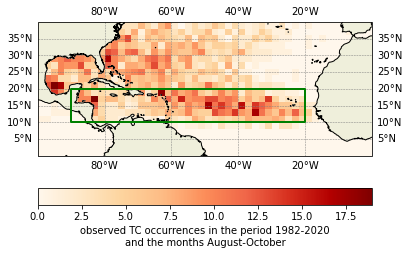

In [87]:
# plot MDR
from shapely.geometry.polygon import Polygon
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
plt.close()
fig,ax = plt.subplots(nrows=1, subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines(color='k', zorder=2)
ax.set_extent([-100,0,0,40], crs=ccrs.PlateCarree() )
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=0.5, color='gray', alpha=1, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

im = ax.pcolormesh(density.lon,density.lat, density, transform=ccrs.PlateCarree(), cmap='OrRd', zorder=0)

plt.colorbar(im, orientation='horizontal', label='observed TC occurrences in the period 1982-2020\nand the months August-October')
ax.add_feature(cartopy.feature.LAND, zorder=1)
ax.add_geometries([Polygon([[-90,10],[-90,20],[-20,20],[-20,10]])], crs=ccrs.PlateCarree(), edgecolor='green', facecolor='none', linewidth=2, zorder=2)
plt.savefig('/home/peter/Projects/tc_emulator/MDR.png', dpi=600)


In [61]:
plt.close()
im = ax.contourf(density.lon,density.lat, density)
plt.show()

NameError: name 'tracks' is not defined